# PLAN

- [x] Acquisition
    - [x] read the csv into a dataframe
- [ ] Preparation
    - [ ] no missing values
    - [x] drop columns that are not needed
    - [x] change case to lower case
    - [x] make sure everything has right dtype
    - [ ] normalize what needs to be normalized
    - [x] rename columns for clarification
- [ ] Exploration
    - [ ] answer ALL questions raised
        - [x] Which locations are the most frequent sites of SSO?
        - [x] Which location have the most volume of overflow?
        - [x] What are most common root causes of SSO?
        - [x] Where do the majority of overflow go?

    - [ ] visualize important findings
    - [ ] decide what TODO items to keep
- [ ] Modeling
    - [ ] predict 
- [ ] Delivery
    - [ ] report
    - [ ] prezi slides
    - [ ] website

# ENVIRONMENT

In [1]:
import os
import acquire_sso as acquire
import prepare_sso as prepare
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm

from datetime import timedelta, datetime
from pylab import rcParams

# to explode the DataFrames and avoid truncation
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from fbprophet import Prophet

# ACQUIRE

#### _Let's read in the data from the csv file and take a peek at te first five records._

In [2]:
df = acquire.read_data('saws-sso.csv')

In [3]:
df.head()

,SSO_ID,INSPKEY,SERVNO,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,SPILL_STOP,HRS,CAUSE,COMMENTS,ACTIONS,WATERSHED,UNITID,UNITID2,DISCHARGE_TO,DISCHARGE_ROUTE,COUNCIL_DISTRICT,FERGUSON,Month,Year,Week,EARZ_ZONE,Expr1029,PIPEDIAM,PIPELEN,PIPETYPE,INSTYEAR,DWNDPTH,UPSDPTH,Inches_No,RainFall_Less3,SPILL ADDRESS,SewerAssetExp,NUM_SPILLS_COMPKEY,NUM_SPILLS_24MOS,PREVSPILL_24MOS,UNITTYPE,ASSETTYPE,LASTCLND,ResponseTime,ResponseDTTM,Public Notice,TIMEINT,Root_Cause,STEPS_TO_PREVENT,SPILL_START_2,SPILL_STOP_2,HRS_2,GAL_2,SPILL_START_3,SPILL_STOP_3,HRS_3,GAL_3
0,6582,567722.0,NaN,3/10/19,3200,THOUSAND OAKS DR,2100,2100.0,2100.0,3/10/2019 1:16:00 PM,3/10/2019 2:40:00 PM,1.400000,Grease,Spill ContainedReturned to SystemArea Cleaned ...,CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,172A2,3,2019,11,0.0,NaN,8.0,16.55,PVC,1997.0,NaN,NaN,NaN,NaN,3200 THOUSAND OAKS DR,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,0.45,10-Mar-19,False,24.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
1,6583,567723.0,NaN,3/10/19,6804,S FLORES ST,80,0.0,80.0,3/10/2019 2:25:00 PM,3/10/2019 3:45:00 PM,1.333333,Grease,Spill ContainedArea Cleaned and Disinfected,CLEANED MAIN,DOS RIOS,24250,24193,STORMDRAIN,None,3.0,251A3,3,2019,11,0.0,NaN,8.0,157.00,PVC,1988.0,NaN,NaN,NaN,NaN,6804 S FLORES,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,1.08,10-Mar-19,False,120.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
2,6581,567714.0,NaN,3/9/19,215,AUDREY ALENE DR,79,0.0,10.0,3/9/2019 6:00:00 PM,3/9/2019 7:30:00 PM,1.500000,Structural,Spill ContainedArea Cleaned and DisinfectedFlu...,CLEANED MAIN,DOS RIOS,2822,3351,ALLEY,None,1.0,190E4,3,2019,10,0.0,NaN,8.0,350.00,CP,1955.0,NaN,NaN,NaN,NaN,215 Audrey Alene Dr,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,1.00,09-Mar-19,False,24.0,NaN,NaN,03/10/2019 09:36,03/10/2019 10:45,1.15,69.0,NaN,NaN,0.0,0.0
3,6584,567713.0,NaN,3/9/19,3602,SE MILITARY DR,83,0.0,83.0,3/9/2019 3:37:00 PM,3/9/2019 5:00:00 PM,1.383333,Grease,Spill ContainedArea Cleaned and DisinfectedFlu...,NaN,SALADO CREEK,92804,92805,EASEMENT,None,3.0,252C3,3,2019,10,0.0,NaN,8.0,213.91,PVC,1983.0,NaN,NaN,NaN,NaN,3602 SE MILITARY DR,NaN,1,1.0,NaN,GRAVITY,Sewer Main,NaN,0.55,09-Mar-19,False,120.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0
4,6580,567432.0,NaN,3/6/19,100,PANSY LN,75,0.0,75.0,3/6/2019 9:40:00 AM,3/6/2019 9:55:00 AM,0.250000,Structural,Spill ContainedArea Cleaned and DisinfectedFlu...,CLEANED MAIN,SALADO CREEK,61141,49543,STREET,None,2.0,192A7,3,2019,10,0.0,NaN,12.0,291.90,CP,1952.0,NaN,NaN,NaN,NaN,100 PANSY LN,NaN,2,2.0,15-Dec-18,GRAVITY,Sewer Main,NaN,0.00,06-Mar-19,False,3.0,NaN,NaN,NaN,NaN,0.00,0.0,NaN,NaN,0.0,0.0


In [4]:
df['UNITTYPE'].value_counts()

GRAVITY       2508
OUTFALL        222
SIPHON         144
ABOVE           83
LATERAL         57
SUBMERSED       51
FORCE           44
STANDARD        29
                 9
A/R              6
JUNCTION         2
IN SIPHON        2
OUT SIPHON       2
PMPCENTSP        2
TANKHOLDIN       2
OTHER            1
SLUDGE           1
PMPSUBM          1
Name: UNITTYPE, dtype: int64

In [5]:
df['ASSETTYPE'].value_counts()

Sewer Main               2925
Sewer Lift Station        108
Sewer Service Line         62
Sewer Manhole              34
Sewer Liftstation          30
Sewer Valve                 7
Sewer Node                  3
Sewer Treatment Plant       3
Sewer Pump                  3
Plant Equipment             2
BYPASS LINE                 1
Bypass                      1
Sewer Force Main            1
Sewer Miscellaneous         1
Name: ASSETTYPE, dtype: int64

In [6]:
df.WATERSHED.value_counts()

DOS RIOS             1572
SALADO CREEK          790
LEON CREEK            668
MEDIO CREEK           146
CCMA (Subscriber)       4
Dos Rios                1
Leon Creek              1
Salado Creek            1
Name: WATERSHED, dtype: int64

In [7]:
(df.WATERSHED == 'LEON CREEK').sum()

668

In [8]:
df[df.WATERSHED == 'Leon Creek']

,SSO_ID,INSPKEY,SERVNO,REPORTDATE,SPILL_ADDRESS,SPILL_ST_NAME,TOTAL_GAL,GALSRET,GAL,SPILL_START,SPILL_STOP,HRS,CAUSE,COMMENTS,ACTIONS,WATERSHED,UNITID,UNITID2,DISCHARGE_TO,DISCHARGE_ROUTE,COUNCIL_DISTRICT,FERGUSON,Month,Year,Week,EARZ_ZONE,Expr1029,PIPEDIAM,PIPELEN,PIPETYPE,INSTYEAR,DWNDPTH,UPSDPTH,Inches_No,RainFall_Less3,SPILL ADDRESS,SewerAssetExp,NUM_SPILLS_COMPKEY,NUM_SPILLS_24MOS,PREVSPILL_24MOS,UNITTYPE,ASSETTYPE,LASTCLND,ResponseTime,ResponseDTTM,Public Notice,TIMEINT,Root_Cause,STEPS_TO_PREVENT,SPILL_START_2,SPILL_STOP_2,HRS_2,GAL_2,SPILL_START_3,SPILL_STOP_3,HRS_3,GAL_3
1703,2795,162383.0,NaN,6/7/12,7523,OLD PEARSALL RD,124,124.0,124.0,6/7/2012 11:33:00 AM,6/7/2012 12:25:00 PM,0.866667,Grease,APPLIED HTH,CLEANED MAIN,Leon Creek,41296,41265,DRAINAGE CULVERT,None,4.0,679D4,6,2012,23,0.0,GREASE,8.0,400.0,PVC,1993.0,NaN,NaN,0.0,0.0,7523 OLD PEARSALL RD,NaN,2,NaN,NaN,GRAVITY,Sewer Main,NaN,NaN,NaN,False,NaN,GREASE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Work with geocoded_saws.csv to clean up zip codes and lat and long

In [9]:
df_geocoded = acquire.read_data('geocoded_saws.csv')

In [10]:
df_geocoded.sewershed.value_counts()

dos rios             1570
salado creek          791
leon creek            670
medio creek           148
ccma (subscriber)       4
Name: sewershed, dtype: int64

In [11]:
df_geocoded.Postal[df_geocoded.sewershed == 'leon creek'].value_counts()

78227    122
78242     99
78228     76
78240     54
78251     45
78238     43
78250     31
78229     29
78249     24
78243     24
78254     19
78257     17
78211     13
78252     11
78221     11
78245     10
78255      8
78253      6
78237      6
78256      6
78015      3
78230      3
78224      3
78264      2
78073      2
1          2
78023      1
Name: Postal, dtype: int64

In [12]:
wrong_zips = [78219, 78218, 78208, 78154, 78244, 77377]

In [13]:
temp = df_geocoded[['spill_street_address', 'Postal', 'sewershed']][df_geocoded['Postal'].isin(wrong_zips)]
temp.sort_values(by='sewershed')

,spill_street_address,Postal,sewershed
386,"1112 muncey, san antonio, tx",78208,dos rios
1314,"4000 ih 10 e, san antonio, tx",78219,dos rios
1315,"700 at and t center pkwy, san antonio, tx",78219,dos rios
1316,"3099 houston st e, san antonio, tx",78219,dos rios
1317,"4065 ih 10 e, san antonio, tx",78219,dos rios
400,"2004 23rd st, san antonio, tx",78208,dos rios
399,"307 spofford, san antonio, tx",78208,dos rios
397,"300 jim st, san antonio, tx",78208,dos rios
396,"1700 rogers ave, san antonio, tx",78208,dos rios
398,"1300 ervin, san antonio, tx",78208,dos rios


In [14]:
temp[temp['sewershed']=='leon creek']

,spill_street_address,Postal,sewershed


#### I changed the following data so that it no longer shows up as errors.
- 32	12014 canyon rock ln, san antonio, tx	77377
    - Closest is in Spring Branch, 78070, but that's north of SAWS area, removed city and changed zip to 1 and removed long and lat

- 257	10710 spirit roam, san antonio, tx	78154
    - Changed to 10710 spirit roam, san antonio, tx 78254
    - (long: -98.704260, lat: 29.525840

- 778	29621 elkhorn ridge, san antonio, tx	78218
    - Changed to 29621 elkhorn ridge, boerne, tx 78015
    - (long: -98.662880, lat: 29.734010)
- also changed 7707 lost creek gap, san antonio, tx
    - changed to 7707 lost creek gap, boerne, tx 78015
    - (long: -98.636370, lat: 29.682290)
- also changed 8219 mystic chase, san antonio, tx
    - changed to 8219 mystic chase, boerne, tx 78015
    - (long: -98.643900, lat: 29.702590)

- 796	8400 redwing dr, san antonio, tx	78219
    - There is no Redwing Drive in SA, closest is north of Medina Lake... ??? removed city and changed zip to 1 and removed long and lat

- 1097	4707 crystal hill, san antonio, tx	78244
    - Changed to 4707 crystal hill, san antonio, tx 78238
    - (long: -98.620500, lat: 29.479150)

- 1131	89 grey, san antonio, tx	78208
    - changed to 89 Grey Bluff, San Antonio, TX 78252
    - (long: -98.62897, lat: 29.343267)

In [15]:
df_geocoded.Postal[df_geocoded.sewershed == 'dos rios'].value_counts()

78201    169
78228    162
78223    156
78207    124
78212    123
78213     83
78221     77
78230     74
78216     73
78210     61
78209     60
78237     54
78214     40
78220     34
78211     33
78229     32
78202     28
78203     26
78226     26
78224     25
78225     22
78204     17
78208     15
78205     12
78249      9
78215      8
78240      6
78245      4
78219      4
78231      4
78264      3
78233      2
78258      2
78257      1
78243      1
Name: Postal, dtype: int64

In [16]:
wrong_for_dos_rios = [77701, 81120, 78232, 78236, 78251, 78252, 
                      78255, 78257, 78259, 78606, 78064]

In [17]:
temp = df_geocoded[['spill_street_address', 'Postal', 'sewershed']][df_geocoded['Postal'].isin(wrong_for_dos_rios)]
temp.sort_values(by=['sewershed', 'Postal'])

,spill_street_address,Postal,sewershed
3083,"17203 nw military hwy, san antonio, tx",78257,dos rios
2943,"4315 rogers rd, san antonio, tx",78251,leon creek
2944,"9765 potranco rd, san antonio, tx",78251,leon creek
2945,"2310 elva forest, san antonio, tx",78251,leon creek
2946,"9926 sable arrow, san antonio, tx",78251,leon creek
2947,"8985 grissom rd, san antonio, tx",78251,leon creek
2948,"9765 potranco rd, san antonio, tx",78251,leon creek
2949,"9765 potranco rd, san antonio, tx",78251,leon creek
2950,"3302 timber view dr, san antonio, tx",78251,leon creek
2951,"1900 ashprington, san antonio, tx",78251,leon creek


In [18]:
temp[temp['sewershed']=='dos rios'].sort_values(by='Postal')

,spill_street_address,Postal,sewershed
3083,"17203 nw military hwy, san antonio, tx",78257,dos rios


I changed the following data so that it no longer shows up as errors.
Except that one address really is at the top of the dos rios sewershed.

- 2600 cima, san antonio, tx	77701	dos rios
    - changed to 2600 cima st, san antonio, tx 78228
    - (long: -98.54377, lat: 29.44466)
    
NOT SURE IF THE NEXT TWO LISTSINGS ARE CORRECT...
- 7500 us hwy 281 n, san antonio, tx	78064	dos rios
    - changed to 7500 us hwy 281 n, san antonio, tx	78216
    - (long: -98.48198, lat: 29.48261)
    
- 7900 us hwy 281 n, san antonio, tx	78232	dos rios
    - changed to 7900 us hwy 281 n, san antonio, tx	78216
    - (long: -98.482997, lat: 29.48876)
    
    
- 100 chappie james way, san antonio, tx	78236	dos rios
    - 100 chappie james way, san antonio, tx	78243
    - (long: -98.59991, lat: 29.3869)
    - also changed 108 chappie james way, san antonio 78243
    - (long: -98.59896, lat: 29.38401)
    
- 105 dillon walk, san antonio, tx	78251	dos rios
    - there is no dillon walk...should this be dillon road???
    - changed to 105 dillon road, san antonio, tx 78002
    - (long: -98.6987, lat:	29.31755)
    
- 12519 switchgrass, san antonio, tx	78252	dos rios
    - looks like correct zip code, but wrong sewershed
    - changed sewershed to medio creek
    - (long: -98.738300, lat: 29.360230)
    
- 6700 mountain top, san antonio, tx	78255	dos rios
    - looks like correct zip code, but wrong sewershed
    - changed sewershed to leon creek
    - (long: -98.660072, lat: 29.688419)
    
- 17203 nw military hwy, san antonio, tx	78257	dos rios
    - all looks correct... top of dos rios sewershed
    
- 800 hanover, san antonio, tx	78259	dos rios
    - changed to 800 hanover, san antonio, tx	78228
    - (long: -98.557060, lat: 29.448790)
    
- 100 pyle, san antonio, tx	78606	dos rios
    - changed to 100 pyle st, san antonio, tx	78223
    - (long: -98.445580, lat: 29.365900)
    
- 500 st agatha, san antonio, tx	81120	dos rios
    - changed to 500 st agatha, san antonio, tx	78207
    - (long: -98.532380, lat: 29.415290)
    

#### Other errors detected through Tableau...
# need to be corrected in csv file

Postal	Sewershed	Spill Street Address	X	Y

Should be medio creek:
- 78245	dos rios	2007 ares cv, san antonio, tx	-98.78637663	29.41156555
- 78245	dos rios	12503 ranch summit, san antonio, tx	-98.74192235	29.42448298
- 78245	dos rios	2380 grosenbacher rd, san antonio, tx	-98.72656996	29.40217192
- 78245	dos rios	2553 struck silver, san antonio, tx	-98.71700874	29.40479113



Should be dos rios:
- 78225	salado creek	4000 ih 35 n, san antonio, tx	-98.512	29.38424129
    - changed sewershed to dos rios
    - changed address to 4000 ih 35 n, san antonio, tx 78214
    - (long: -98.511903, lat: 29.382335)



Should be leon creek:
- 78228	salado creek	83 arrowhead dr, san antonio, tx	-98.57819317	29.47707174
    - changed sewershed to leon creek
    - (long: -98.573485, lat: 29.482164)





Changed to leon creek to match sewershed of others on this street:
- 10/24/18 0:00	2448400	0	2448400	10/24/18 13:50	10/28/18 13:29	95.65	i/i		monitored area	leon creek	1210	42319	creek bed - spilled into leon creek	leon creek		2.28E+08	10	2018	43	0	RAIN EVENT	54	1335	rcp	1965	0.79	0.49	10	9	outfall	sewer main		TRUE	RAIN EVENT	Capacity Project, 			0	0			0	0	108 chappie james way, san antonio, tx	78243	122	-98.59896	29.38401


Changed zip code:
- 78233	dos rios	2535 ih 35 n, san antonio, tx	-98.36316044	29.54880533
    - changed to 2535 ih 35 n, san antonio, tx 78208
    - (long: -98.452467, lat: 29.439920)
- 78233 dos rios  2623 ih 35 n, san antonio, tx -98.36316044	29.54880533
    - changed to 2623 ih 35 n, san antonio, tx 78211
    - (long: -98.450922, lat: 29.439939)
    
- 78237 salado creek 132 afton oaks e, san antonio, tx
    - changed to 132 afton oaks e, san antonio, tx 78232
    - (long: -98.482517, lat: 29.608570)
    
- 78249	salado creek	4100 kingston, san antonio, tx	-98.60637544	29.569293
    - changed to 4100 kingston, san antonio, tx 78218
    - (long: -98.409455, lat: 29.502832)
    
- 78249	salado creek	6011 kingston, san antonio, tx	-98.60416452	29.57100288
    - changed to 6011 kingston, san antonio, tx 78218
    - (long: -98.410942, lat: 29.492495)
    
- 78249	salado creek	6000 kingston, san antonio, tx	-98.60377135	29.57104561
    - changed to 6000 kingston, san antonio, tx 78218
    - (long: -98.409455, lat: 29.502832)
    
- 78249	salado creek	5800 kingston, san antonio, tx	   
    - changed to 5800 kingston, san antonio, tx 78218
    - (long: -98.409455, lat: 29.502832)
    
- 78238	salado creek	4906 wurzbach pkwy, san antonio, tx	-98.61201237	29.47850521
    - changed to 4906 wurzbach pkwy, san antonio, tx 78233
    - (long: -98.38278, lat: 29.545654)
    
- 78260	medio creek	1605 dove canyon, san antonio, tx	-98.46736392	29.68591598
    - changed to 1605 dove canyon, san antonio, tx 78245 
    - (long: -98.718503, lat: 29.419498)
    
- 78249	medio creek	8541 lake vista, san antonio, tx	-98.65468727	29.55706988
    - changed to 8541 lake vista, san antonio, tx 78227
    - (long: -98.650678, lat: 29.394092)
    
Lat and Long were wrong:
- 78245	leon creek	2380 grosenbacher rd, san antonio, tx	-98.72656996	29.40217192
    - changed (long: -98.72651, lat: 29.407868)

# PREPARE -- using geocoded_saws.csv on code that DD wrote

#### _Let's convert the column to lowercase to make them easier to work with and also rename the column names for clarity._

In [19]:
df = prepare.lowercase_and_rename(df_geocoded)

In [20]:
df.head().T

,0,1,2,3,4
report_date,2/4/19 0:00,1/2/16 0:00,4/4/09 0:00,3/7/17 0:00,1/26/16 0:00
total_gallons,150,1200,100,4000,450
gallons_returned,0,0,NaN,2500,0
gallons_1,150,1200,100,4000,450
spill_start_1,2/4/19 21:00,1/2/16 17:03,4/4/09 12:15,3/7/17 20:35,1/26/16 9:00
spill_stop_1,2/4/19 21:30,1/2/16 19:03,4/4/09 13:15,3/7/17 21:15,1/26/16 9:00
hours_1,0.5,2,1,0.666667,0
cause,contractor,grease,grease,grease,structural
comments,spill containedarea cleaned and disinfectedflu...,spill containedarea cleaned and disinfectedflu...,applied hth,spill containedreturned to systemarea cleaned ...,NaN
actions,cleaned main,cleaned main,cleaned main,cleaned main,repaired force main


#### _Let's make copies of the original dataframe before dropping some columns and rows to cover scenarios where we uncover more information about the variables._

In [21]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

In [22]:
df.columns

Index(['report_date', 'total_gallons', 'gallons_returned', 'gallons_1', 'spill_start_1', 'spill_stop_1', 'hours_1', 'cause', 'comments', 'actions', 'sewershed', 'unit_id_1', 'unit_id_2', 'discharge_to', 'discharge_route', 'council_district', 'ferguson', 'month', 'year', 'week', 'edwards_zone', 'expr_1029', 'pipe_diameter', 'pipe_length', 'pipe_type', 'installation_year', 'inches_no', 'rainfall_less_3', 'num_spills_compkey', 'num_spills_24mos', 'unit_type', 'asset_type', 'last_cleaned', 'public_notice', 'root_cause', 'steps_to_prevent', 'spill_start_2', 'spill_stop_2', 'hours_2', 'gallons_2', 'spill_start_3', 'spill_stop_3', 'hours_3', 'gallons_3', 'spill_street_address', 'postal', 'postalext', 'x', 'y'], dtype='object')

### Note that I changed watershed to sewershed...

In [24]:
df.sewershed.value_counts()

dos rios             1570
salado creek          791
leon creek            670
medio creek           148
ccma (subscriber)       4
Name: sewershed, dtype: int64

In [25]:
df[df.sewershed == 'Leon Creek']

,report_date,total_gallons,gallons_returned,gallons_1,spill_start_1,spill_stop_1,hours_1,cause,comments,actions,sewershed,unit_id_1,unit_id_2,discharge_to,discharge_route,council_district,ferguson,month,year,week,edwards_zone,expr_1029,pipe_diameter,pipe_length,pipe_type,installation_year,inches_no,rainfall_less_3,num_spills_compkey,num_spills_24mos,unit_type,asset_type,last_cleaned,public_notice,root_cause,steps_to_prevent,spill_start_2,spill_stop_2,hours_2,gallons_2,spill_start_3,spill_stop_3,hours_3,gallons_3,spill_street_address,postal,postalext,x,y


#### _Let's prepare df1 for EDA_
0. remove columns that do not add information
0. drop the columns that are no longer needed.
0. Make new variable of whether this incident involved two or more spills within 24 hours
0. Remove redundant columns
0. Rename spill details into simpler names
0. Change column values to lowercase
0. Change address into titlecase
0. Fix the data types
0. Fill nan's
0. Change data type to datetime

In [26]:
df1 = prepare.ready_df1(df1)
df1

KeyError: "['sso_id' 'inspection_key' 'service_number' 'downstream_depth'\n 'upstream_depth' 'sewer_asset_exp' 'previous_spill_24mos'] not found in axis"

In [27]:
df1.dtypes

report_date              object
total_gallons             int64
gallons_returned        float64
gallons_1               float64
spill_start_1            object
spill_stop_1             object
hours_1                 float64
cause                    object
comments                 object
actions                  object
sewershed                object
unit_id_1                object
unit_id_2                object
discharge_to             object
discharge_route          object
council_district        float64
ferguson                 object
month                     int64
year                      int64
week                      int64
edwards_zone            float64
expr_1029                object
pipe_diameter           float64
pipe_length             float64
pipe_type                object
installation_year       float64
inches_no               float64
rainfall_less_3         float64
num_spills_compkey        int64
num_spills_24mos        float64
unit_type                object
asset_ty

#### _Let's assign a variable with all numerical column names._

In [28]:
df1_numerical_columns = list(df1.select_dtypes(include=[np.number]).columns.values)
df1_numerical_columns

['total_gallons',
 'gallons_returned',
 'gallons_1',
 'hours_1',
 'council_district',
 'month',
 'year',
 'week',
 'edwards_zone',
 'pipe_diameter',
 'pipe_length',
 'installation_year',
 'inches_no',
 'rainfall_less_3',
 'num_spills_compkey',
 'num_spills_24mos',
 'hours_2',
 'gallons_2',
 'hours_3',
 'gallons_3',
 'postal',
 'postalext',
 'x',
 'y']

#### _Let's assign a variable with all non-numerical column names._

In [29]:
df1_non_numerical_columns = list(df1.select_dtypes(exclude=[np.number]).columns.values)
df1_non_numerical_columns

['report_date',
 'spill_start_1',
 'spill_stop_1',
 'cause',
 'comments',
 'actions',
 'sewershed',
 'unit_id_1',
 'unit_id_2',
 'discharge_to',
 'discharge_route',
 'ferguson',
 'expr_1029',
 'pipe_type',
 'unit_type',
 'asset_type',
 'last_cleaned',
 'public_notice',
 'root_cause',
 'steps_to_prevent',
 'spill_start_2',
 'spill_stop_2',
 'spill_start_3',
 'spill_stop_3',
 'spill_street_address']

In [30]:
df1.last_cleaned.value_counts(dropna=False)

NaN          2082
23-Sep-09       6
11-May-12       5
22-Oct-09       5
22-Aug-09       5
28-Dec-09       4
7-Jan-10        4
7-Dec-09        4
29-Feb-12       4
19-Jun-13       4
25-Nov-09       4
1-Jun-10        4
20-Oct-09       4
18-Apr-09       4
23-Nov-09       4
10-Nov-11       3
24-Jun-09       3
9-Aug-10        3
12-Nov-09       3
15-Mar-10       3
21-Mar-11       3
4-Jan-10        3
19-Feb-10       3
8-Apr-10        3
3-Aug-11        3
22-Nov-13       3
12-Feb-11       3
5-Feb-10        3
17-Oct-13       3
22-Aug-13       3
22-Dec-09       3
23-Oct-09       3
18-Jun-14       3
21-Sep-10       3
12-Aug-10       3
19-Oct-11       3
21-Sep-11       3
22-Feb-10       3
11-Feb-10       3
29-Aug-09       3
19-Nov-12       3
4-Oct-10        3
7-Oct-10        3
3-Oct-11        3
17-Dec-09       3
1-May-09        3
8-Mar-10        3
25-Mar-11       3
23-Sep-13       3
11-Apr-14       3
7-May-09        3
17-Mar-09       3
26-May-11       3
10-Dec-09       3
27-Aug-10       3
7-Dec-11  

In [31]:
df1.head(6).T

,0,1,2,3,4,5
report_date,2/4/19 0:00,1/2/16 0:00,4/4/09 0:00,3/7/17 0:00,1/26/16 0:00,10/25/11 0:00
total_gallons,150,1200,100,4000,450,10
gallons_returned,0,0,NaN,2500,0,0
gallons_1,150,1200,100,4000,450,10
spill_start_1,2/4/19 21:00,1/2/16 17:03,4/4/09 12:15,3/7/17 20:35,1/26/16 9:00,10/25/11 9:06
spill_stop_1,2/4/19 21:30,1/2/16 19:03,4/4/09 13:15,3/7/17 21:15,1/26/16 9:00,10/25/11 10:00
hours_1,0.5,2,1,0.666667,0,0.9
cause,contractor,grease,grease,grease,structural,debris
comments,spill containedarea cleaned and disinfectedflu...,spill containedarea cleaned and disinfectedflu...,applied hth,spill containedreturned to systemarea cleaned ...,NaN,hth-contractor's plug in main
actions,cleaned main,cleaned main,cleaned main,cleaned main,repaired force main,cleaned main


In [32]:
prepare.missing_values_col(df1)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
report_date,0,0.000000,0,0.0,0,0.0
total_gallons,0,0.000000,0,0.0,0,0.0
gallons_returned,475,14.923029,0,0.0,0,0.0
gallons_1,0,0.000000,0,0.0,0,0.0
spill_start_1,0,0.000000,0,0.0,0,0.0
spill_stop_1,0,0.000000,0,0.0,0,0.0
hours_1,3,0.094251,0,0.0,0,0.0
cause,0,0.000000,0,0.0,0,0.0
comments,533,16.745209,0,0.0,0,0.0
actions,8,0.251335,0,0.0,0,0.0


# EXPLORE

#### _Looking for the repeat offenders..._

In [33]:
df1.num_spills_24mos[df1.num_spills_24mos > 1].value_counts()

2.0     180
3.0      75
4.0      32
5.0      27
6.0      19
7.0      12
8.0       7
9.0       5
10.0      1
11.0      1
12.0      1
13.0      1
Name: num_spills_24mos, dtype: int64

#### _Locations of the most frequent SSOs in 2 years_

In [34]:
df1[['spill_street_address']][df1.num_spills_24mos >= 9]

,spill_street_address
993,"10800 entrance rd ne, san antonio, tx"
996,"10800 entrance rd ne, san antonio, tx"
998,"10800 entrance rd ne, san antonio, tx"
999,"10823 entrance rd ne, san antonio, tx"
1001,"10700 entrance rd ne, san antonio, tx"
1766,"6606 swiss oaks, san antonio, tx"
1767,"6606 swiss oaks, san antonio, tx"
1786,"6606 swiss oaks, san antonio, tx"
2695,"108 chappie james way, san antonio, tx"


#### _Total number of gallons spilled by the most frequent SSOs in 2 years_

In [35]:
df1.total_gallons[df1.num_spills_24mos >= 9].agg('sum')

3538455

In [37]:
df1.columns

Index(['report_date', 'total_gallons', 'gallons_returned', 'gallons_1', 'spill_start_1', 'spill_stop_1', 'hours_1', 'cause', 'comments', 'actions', 'sewershed', 'unit_id_1', 'unit_id_2', 'discharge_to', 'discharge_route', 'council_district', 'ferguson', 'month', 'year', 'week', 'edwards_zone', 'expr_1029', 'pipe_diameter', 'pipe_length', 'pipe_type', 'installation_year', 'inches_no', 'rainfall_less_3', 'num_spills_compkey', 'num_spills_24mos', 'unit_type', 'asset_type', 'last_cleaned', 'public_notice', 'root_cause', 'steps_to_prevent', 'spill_start_2', 'spill_stop_2', 'hours_2', 'gallons_2', 'spill_start_3', 'spill_stop_3', 'hours_3', 'gallons_3', 'spill_street_address', 'postal', 'postalext', 'x', 'y'], dtype='object')

# what were 'hours' and 'multiple_spills' supposed to be?

In [38]:
# df1[['spill_street_address', 'total_gallons', 'hours', 'root_cause',
#      'unit_type', 'asset_type', 'last_cleaned', 'multiple_spills',
#      'discharge_to', 'discharge_route']][df1.num_spills_24mos >= 9]

In [39]:
df1[['spill_street_address', 'total_gallons', 'root_cause',
     'unit_type', 'asset_type', 'last_cleaned', 
     'discharge_to', 'discharge_route']][df1.num_spills_24mos >= 9]

,spill_street_address,total_gallons,root_cause,unit_type,asset_type,last_cleaned,discharge_to,discharge_route
993,"10800 entrance rd ne, san antonio, tx",12000,RAIN EVENT,gravity,sewer main,NaN,creek bed - spilled into salado creek,salado creek
996,"10800 entrance rd ne, san antonio, tx",78000,RAIN EVENT,gravity,sewer main,NaN,creek bed - spilled into salado creek,none
998,"10800 entrance rd ne, san antonio, tx",100,OTHER,gravity,sewer main,NaN,ground,none
999,"10823 entrance rd ne, san antonio, tx",200,BY PASS PUMP LEAK,gravity,sewer main,NaN,ground,none
1001,"10700 entrance rd ne, san antonio, tx",13100,OTHER,gravity,sewer main,NaN,ground,salado creek
1766,"6606 swiss oaks, san antonio, tx",48000,RAIN EVENT,outfall,sewer main,NaN,creek bed - spilled into leon creek,leon creek
1767,"6606 swiss oaks, san antonio, tx",815355,RAIN EVENT,outfall,sewer main,NaN,creek bed - spilled into leon creek,leon creek
1786,"6606 swiss oaks, san antonio, tx",123300,RAIN EVENT,outfall,sewer main,NaN,creek bed - spilled into leon creek,leon creek
2695,"108 chappie james way, san antonio, tx",2448400,RAIN EVENT,outfall,sewer main,NaN,creek bed - spilled into leon creek,leon creek


#### _Most common root causes of SSOs_

In [40]:
df1.root_cause.value_counts()

STRUCTURAL           1237
GREASE                610
DEBRIS                443
RAIN EVENT            353
CONTRACTOR            164
LIFT STATION          125
OTHER                  61
VANDALISM              48
RAIN EVENT             48
VANDALISM              24
ROOTS                  22
LIFT STATION           15
I/I                    12
CONTRACTOR              8
BY PASS PUMP LEAK       3
Debris                  1
Grease                  1
OTHER                   1
Name: root_cause, dtype: int64

- [ ] **TODO:** Find a way to flesh out the address using regex to account for typos etc.
- [ ] **TODO:** Maybe try using unit id's instead of addresses.
- [ ] **TODO:** Drill down to only the top 3-5 locations.
- [ ] **TODO:** Compare predictions between preventing SSO on the most frequents versus not preventing.
- [ ] **TODO:** What is causing the spills on these top 3-5 locations?

In [41]:
df1.head(4).T

,0,1,2,3
report_date,2/4/19 0:00,1/2/16 0:00,4/4/09 0:00,3/7/17 0:00
total_gallons,150,1200,100,4000
gallons_returned,0,0,NaN,2500
gallons_1,150,1200,100,4000
spill_start_1,2/4/19 21:00,1/2/16 17:03,4/4/09 12:15,3/7/17 20:35
spill_stop_1,2/4/19 21:30,1/2/16 19:03,4/4/09 13:15,3/7/17 21:15
hours_1,0.5,2,1,0.666667
cause,contractor,grease,grease,grease
comments,spill containedarea cleaned and disinfectedflu...,spill containedarea cleaned and disinfectedflu...,applied hth,spill containedreturned to systemarea cleaned ...
actions,cleaned main,cleaned main,cleaned main,cleaned main


In [42]:
df1[['spill_street_address', 'unit_id_1','unit_id_2', 'unit_type', 'asset_type']].head(15)

,spill_street_address,unit_id_1,unit_id_2,unit_type,asset_type
0,12014 canyon rock ln,1004735,1004741,gravity,sewer main
1,8400 redwing dr,33522,33680,gravity,sewer main
2,"105 dillon road, san antonio, tx",88137,88288,gravity,sewer main
3,"7707 lost creek gap, boerne, tx",402634,402621,gravity,sewer main
4,"29621 elkhorn ridge, boerne, tx",LS284,NaN,submersed,sewer liftstation
5,"8219 mystic chase, boerne, tx",498752,498751,gravity,sewer main
6,"12550 leslie rd, san antonio, tx",40921,100351,gravity,sewer main
7,"10701 fischer rd, san antonio, tx",LS219,NaN,above,sewer lift station
8,"10701 fischer rd, san antonio, tx",LS219,NaN,above,sewer lift station
9,"2307 camberly vw, san antonio, tx",413173,413174,gravity,sewer main


- [ ] **TODO:** Maybe we can do some kind of clustering to group problem areas.

In [43]:
df1.unit_id_1.value_counts()[df1.unit_id_1.value_counts() > 7]

52470     15
LS200     14
1187      13
903059    12
LS199     12
903060    10
47822     10
LS188     10
62085     10
1210      10
29988      8
LS201      8
424896     8
11989      8
Name: unit_id_1, dtype: int64

In [44]:
df1.unit_id_2.value_counts()[df1.unit_id_2.value_counts() > 7]

1074      13
52677     13
71380     12
903059    10
46546      9
62088      9
922726     9
79942      8
424898     8
499663     8
16276      8
Name: unit_id_2, dtype: int64

In [45]:
df1['root_cause'].value_counts()

STRUCTURAL           1237
GREASE                610
DEBRIS                443
RAIN EVENT            353
CONTRACTOR            164
LIFT STATION          125
OTHER                  61
VANDALISM              48
RAIN EVENT             48
VANDALISM              24
ROOTS                  22
LIFT STATION           15
I/I                    12
CONTRACTOR              8
BY PASS PUMP LEAK       3
Debris                  1
Grease                  1
OTHER                   1
Name: root_cause, dtype: int64

In [46]:
df1['spill_street_address'].value_counts()[df1.spill_street_address.value_counts() > 7]

6606 swiss oaks, san antonio, tx          24
108 chappie james way, san antonio, tx    20
700 holbrook, san antonio, tx             16
10800 entrance rd ne, san antonio, tx     14
6305 cagnon rd, san antonio, tx           13
1800 austin hwy, san antonio, tx          12
23500 ih 10 w, san antonio, tx            12
1427 harry wurzbach, san antonio, tx      12
6785 cagnon rd, san antonio, tx           12
668 holbrook, san antonio, tx             10
10102 us hwy 90 w, san antonio, tx         9
3847 thousand oaks, san antonio, tx        8
Name: spill_street_address, dtype: int64

#### _Looking for locations with most SSOs that are also caused by grease._

In [47]:
df1.columns

Index(['report_date', 'total_gallons', 'gallons_returned', 'gallons_1', 'spill_start_1', 'spill_stop_1', 'hours_1', 'cause', 'comments', 'actions', 'sewershed', 'unit_id_1', 'unit_id_2', 'discharge_to', 'discharge_route', 'council_district', 'ferguson', 'month', 'year', 'week', 'edwards_zone', 'expr_1029', 'pipe_diameter', 'pipe_length', 'pipe_type', 'installation_year', 'inches_no', 'rainfall_less_3', 'num_spills_compkey', 'num_spills_24mos', 'unit_type', 'asset_type', 'last_cleaned', 'public_notice', 'root_cause', 'steps_to_prevent', 'spill_start_2', 'spill_stop_2', 'hours_2', 'gallons_2', 'spill_start_3', 'spill_stop_3', 'hours_3', 'gallons_3', 'spill_street_address', 'postal', 'postalext', 'x', 'y'], dtype='object')

In [48]:
df1['counts'] = df1.root_cause
df1['counts'] = df1.groupby(['spill_street_address']).transform('count')
df1

,report_date,total_gallons,gallons_returned,gallons_1,spill_start_1,spill_stop_1,hours_1,cause,comments,actions,sewershed,unit_id_1,unit_id_2,discharge_to,discharge_route,council_district,ferguson,month,year,week,edwards_zone,expr_1029,pipe_diameter,pipe_length,pipe_type,installation_year,inches_no,rainfall_less_3,num_spills_compkey,num_spills_24mos,unit_type,asset_type,last_cleaned,public_notice,root_cause,steps_to_prevent,spill_start_2,spill_stop_2,hours_2,gallons_2,spill_start_3,spill_stop_3,hours_3,gallons_3,spill_street_address,postal,postalext,x,y,counts
0,2/4/19 0:00,150,0.0,150.0,2/4/19 21:00,2/4/19 21:30,0.500000,contractor,spill containedarea cleaned and disinfectedflu...,cleaned main,leon creek,1004735,1004741,drainage culvert,leon creek,NaN,165F8,2,2019,6,0.0,CONTRACTOR,8.0,291.540276,pvc,2016.0,NaN,NaN,1,1.0,gravity,sewer main,NaN,False,CONTRACTOR,"Increase FCS,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,12014 canyon rock ln,1,NaN,NaN,NaN,1
1,1/2/16 0:00,1200,0.0,1200.0,1/2/16 17:03,1/2/16 19:03,2.000000,grease,spill containedarea cleaned and disinfectedflu...,cleaned main,leon creek,33522,33680,ground,none,8.0,1.88E+03,1,2016,1,0.0,STRUCTURAL,8.0,320.010000,pvc,1985.0,0.82,0.16,1,1.0,gravity,sewer main,NaN,False,STRUCTURAL,"Point Repair,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,8400 redwing dr,1,NaN,NaN,NaN,1
2,4/4/09 0:00,100,NaN,100.0,4/4/09 12:15,4/4/09 13:15,1.000000,grease,applied hth,cleaned main,medio creek,88137,88288,drainage culvert,NaN,2.0,6.17E+05,4,2009,14,NaN,STRUCTURAL,8.0,71.600000,vcp,1957.0,NaN,NaN,1,NaN,gravity,sewer main,NaN,False,STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"105 dillon road, san antonio, tx",78002,NaN,-98.698700,29.317550,1
3,3/7/17 0:00,4000,2500.0,4000.0,3/7/17 20:35,3/7/17 21:15,0.666667,grease,spill containedreturned to systemarea cleaned ...,cleaned main,leon creek,402634,402621,drainage culvert - over the edwards aquifer co...,none,NaN,127F1,3,2017,10,0.0,DEBRIS,18.0,365.000000,pvc,2007.0,0.00,1.03,1,1.0,gravity,sewer main,NaN,False,DEBRIS,"Increase FCS,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,"7707 lost creek gap, boerne, tx",78015,NaN,-98.636370,29.682290,1
4,1/26/16 0:00,450,0.0,450.0,1/26/16 9:00,1/26/16 9:00,0.000000,structural,NaN,repaired force main,leon creek,LS284,NaN,ground ( over edwards aquifer recharge zone ),none,NaN,107B1,1,2016,5,0.0,CONTRACTOR,NaN,NaN,NaN,2015.0,0.28,0.00,1,1.0,submersed,sewer liftstation,NaN,False,CONTRACTOR,"Point Repair,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,"29621 elkhorn ridge, boerne, tx",78015,NaN,-98.662880,29.734010,1
5,10/25/11 0:00,10,0.0,10.0,10/25/11 9:06,10/25/11 10:00,0.900000,debris,hth-contractor's plug in main,cleaned main,leon creek,498752,498751,street,none,NaN,NaN,10,2011,44,NaN,DEBRIS,8.0,343.300000,pvc,2011.0,0.00,0.00,1,NaN,gravity,sewer main,NaN,False,DEBRIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8219 mystic chase, boerne, tx",78015,6578.0,-98.643900,29.702590,1
6,2/6/13 0:00,300,0.0,300.0,2/6/13 14:16,2/6/13 17:00,2.733333,grease,area cleaned and disinfected,cleaned main,leon creek,40921,100351,stormdrain,none,NaN,NaN,2,2013,6,NaN,STRUCTURAL,8.0,374.000000,pvc,1991.0,0.01,0.01,1,NaN,gravity,sewer main,NaN,False,STRUCTURAL,"Increase FCS,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"12550 leslie rd, san antonio, tx",78023,4740.0,-98.680875,29.559934,1
7,5/25/13 0:00,10000,NaN,10000.0,5/25/13 7:15,5/25/13 12:30,5.250000,i/i,lift station 219 overflow due to heavy rain,cleaned area,leon creek,LS219,NaN,ground,none,NaN,679F6,5,2013,21,0.0,LIFT STATION,NaN,NaN,NaN,1999.0,9.87,2.33,2,1.0,above,sewer lift station,NaN,False,LIFT STATION,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10701 fischer rd, san antonio, tx",78073,NaN,-98.620251,29.315129,2
8,8/18/12 0:00,22053,NaN,22053.0,8/18/12 22:00,8/19/12 23:00,25.000000,lift station,verbattim alarm turned off/repaired @ l/s 219,applied hth,leon creek,LS219,NaN,ground,none,NaN,679F6,8,2012,33,0.0,LIFT STATION,NaN,NaN,NaN,1999.0,0.05,0.00,2,NaN,above,sewer lift station,NaN,False,LIFT STATION,NaN,NaN,NaN,NaN,NaN,Na

#### _Below shows the most frequent SSOs that are caused by grease._

In [49]:
df1.loc[(df1['counts'] >= 7) & (df1['root_cause'] == 'grease')]

,report_date,total_gallons,gallons_returned,gallons_1,spill_start_1,spill_stop_1,hours_1,cause,comments,actions,sewershed,unit_id_1,unit_id_2,discharge_to,discharge_route,council_district,ferguson,month,year,week,edwards_zone,expr_1029,pipe_diameter,pipe_length,pipe_type,installation_year,inches_no,rainfall_less_3,num_spills_compkey,num_spills_24mos,unit_type,asset_type,last_cleaned,public_notice,root_cause,steps_to_prevent,spill_start_2,spill_stop_2,hours_2,gallons_2,spill_start_3,spill_stop_3,hours_3,gallons_3,spill_street_address,postal,postalext,x,y,counts


#### _Below shows the most devastating SSOs by volume._

In [50]:
df1[df1.total_gallons > 1500000]

,report_date,total_gallons,gallons_returned,gallons_1,spill_start_1,spill_stop_1,hours_1,cause,comments,actions,sewershed,unit_id_1,unit_id_2,discharge_to,discharge_route,council_district,ferguson,month,year,week,edwards_zone,expr_1029,pipe_diameter,pipe_length,pipe_type,installation_year,inches_no,rainfall_less_3,num_spills_compkey,num_spills_24mos,unit_type,asset_type,last_cleaned,public_notice,root_cause,steps_to_prevent,spill_start_2,spill_stop_2,hours_2,gallons_2,spill_start_3,spill_stop_3,hours_3,gallons_3,spill_street_address,postal,postalext,x,y,counts
569,5/25/13 0:00,1525000,NaN,1150000.0,5/25/13 11:50,5/26/13 7:00,19.166670,i/i,"resealed 54"""" siphon boxes",cleaned area,dos rios,458341,NaN,creek bed,san antonio river,3.0,650F3,5,2013,21,0.0,RAIN EVENT,NaN,NaN,NaN,NaN,9.87,2.33,1,NaN,junction,sewer manhole,NaN,True,RAIN EVENT,Other,5/26/13 11:45,5/26/13 18:00,6.25,375000.0,NaN,NaN,NaN,NaN,"1135 mission rd, san antonio, tx",78210,4505.0,-98.489892,29.385866,5
887,10/20/10 0:00,4442000,NaN,4442000.0,10/20/10 9:00,10/27/10 11:00,170.000000,break in main,repaired force main - l/s # 172,repaired broken main,dos rios,13440,14063,creek bed,san antonio river,3.0,683D1,10,2010,43,NaN,STRUCTURAL,30.0,122.58,frp,1990.0,0.00,0.00,2,NaN,force,sewer main,NaN,True,STRUCTURAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"8600 mission pkwy, san antonio, tx",78214,NaN,-98.467128,29.338751,6
1158,9/22/18 0:00,1640538,0.0,1238910.0,9/22/18 8:40,9/23/18 4:00,19.333333,i/i,NaN,diluted by heavy rainwater,salado creek,47427,46546,creek bed - spilled into salado creek,salado creek,10.0,192C4,9,2018,38,NaN,RAIN EVENT,48.0,54.81,rcp,1965.0,1.86,0.56,3,3.0,outfall,sewer main,NaN,True,RAIN EVENT,"Capacity Project,",9/23/18 14:42,9/24/18 5:00,14.30,401628.0,NaN,NaN,0.00,0.0,"1800 austin hwy, san antonio, tx",78218,1713.0,-98.422365,29.499304,12
1179,12/3/16 0:00,1560928,0.0,155103.0,12/3/16 14:08,12/4/16 9:15,19.120000,i/i,NaN,diluted by heavy rain water,salado creek,47809,48516,creek bed - spilled into salado creek,salado creek,2.0,192D6,12,2016,49,0.0,RAIN EVENT,48.0,109.01,rcp,1973.0,3.84,0.66,4,2.0,outfall,sewer main,NaN,True,RAIN EVENT,"Capacity Project,",12/4/16 14:00,12/6/16 3:40,37.67,1405825.0,NaN,NaN,0.00,0.0,"668 holbrook, san antonio, tx",78218,NaN,-98.410497,29.480202,10
1190,6/2/16 0:00,6026731,0.0,6026731.0,6/2/16 11:09,6/6/16 7:30,92.350000,i/i,NaN,diluted by heavy rainwater,salado creek,47822,922726,creek bed - spilled into salado creek,salado creek,2.0,192D7,6,2016,23,0.0,RAIN EVENT,0.0,5.89,NaN,1973.0,2.34,2.73,6,6.0,outfall,sewer main,NaN,True,RAIN EVENT,"Capacity Project,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,"700 holbrook, san antonio, tx",78218,NaN,-98.411135,29.480730,16
1192,5/18/16 0:00,2754790,0.0,2754790.0,5/17/16 18:28,5/21/16 3:00,80.530000,i/i,NaN,diluted by heavy rainwater,salado creek,990827,48236,creek bed - spilled into salado creek,salado creek,2.0,1.92E+09,5,2016,21,0.0,RAIN EVENT,0.0,0.00,NaN,2015.0,0.14,1.71,1,1.0,outfall,sewer main,NaN,True,RAIN EVENT,"Capacity Project,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,"700 holbrook, san antonio, tx",78218,NaN,-98.411135,29.480730,16
1450,1/15/10 0:00,3570000,NaN,3570000.0,1/15/10 2:00,1/16/10 3:00,25.000000,i/i,"added 18"""" by pass",added by pass,dos rios,16451,20815,creek bed,six mile creek,3.0,682B1,1,2010,3,NaN,CONTRACTOR,36.0,1005.00,rcp,1949.0,1.81,1.77,2,NaN,outfall,sewer main,NaN,True,CONTRACTOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"300 petaluma blvd e, san antonio, tx",78221,3337.0,-98.497193,29.339103,2
1779,9/20/18 0:00,13304550,0.0,13304550.0,9/20/18 9:45,11/19/18 1:30,620.070000,i/i,NaN,monitored area,leon creek,903059,71380,creek bed - spilled into leon creek,leon creek,6.0,208B8,9,2018,38,0.0,RAIN EVENT,42.0,1301.00,rcp,1973.0,0.56,0.00,5,5.0,outfall,sewer main,NaN,True,RAIN EVENT,"Capacity Project,",NaN,NaN,0.00,0.0,NaN,NaN,0.00,0.0,"6606 swiss oaks, san antonio, tx",78227,1268.0,-98.619312,29.421530,24
1812,6/2/16 0:00,2050500,0.0,2050500.0,6/2/16 11:45,6/6/16 12:30

In [51]:
df1[df1.total_gallons > 1500000].shape

(13, 50)

In [52]:
df1.installation_year.value_counts().sort_index()

1899.0      4
1900.0      5
1904.0      1
1906.0      7
1909.0      3
1910.0      1
1911.0      1
1912.0      1
1914.0      2
1915.0      4
1916.0      6
1918.0      6
1920.0     15
1921.0      1
1922.0      3
1923.0      7
1925.0      7
1926.0      5
1927.0     19
1928.0     18
1929.0      6
1930.0      7
1931.0      2
1933.0      1
1934.0      3
1935.0      6
1937.0      2
1939.0      4
1940.0      1
1941.0      4
1944.0      1
1945.0     14
1946.0     36
1947.0     17
1948.0     51
1949.0     40
1950.0     58
1951.0     19
1952.0     25
1953.0     19
1954.0     36
1955.0     27
1956.0     39
1957.0     35
1958.0     28
1959.0     58
1960.0     42
1961.0     33
1962.0     38
1963.0     61
1964.0     46
1965.0     89
1966.0     49
1967.0     41
1968.0     43
1969.0     27
1970.0     36
1971.0     36
1972.0     59
1973.0    128
1974.0     55
1975.0     28
1976.0     40
1977.0     43
1978.0     46
1979.0     38
1980.0     39
1981.0     25
1982.0     47
1983.0     74
1984.0     45
1985.0

#### _Spills by installation year._

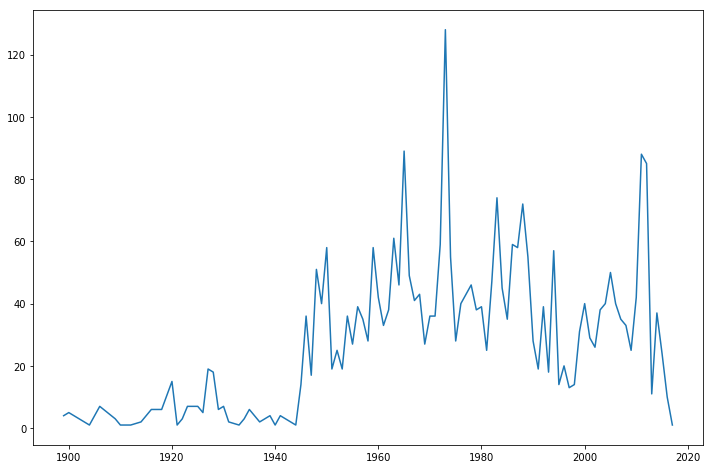

In [53]:
plt.figure(figsize=(12,8))
plt.plot(df1[df1.installation_year < 9999].groupby('installation_year')['spill_street_address'].count())

In [54]:
df1.year.value_counts().sort_index()

2009    383
2010    538
2011    354
2012    374
2013    282
2014    196
2015    263
2016    304
2017    193
2018    259
2019     37
Name: year, dtype: int64

#### _Spills by year._

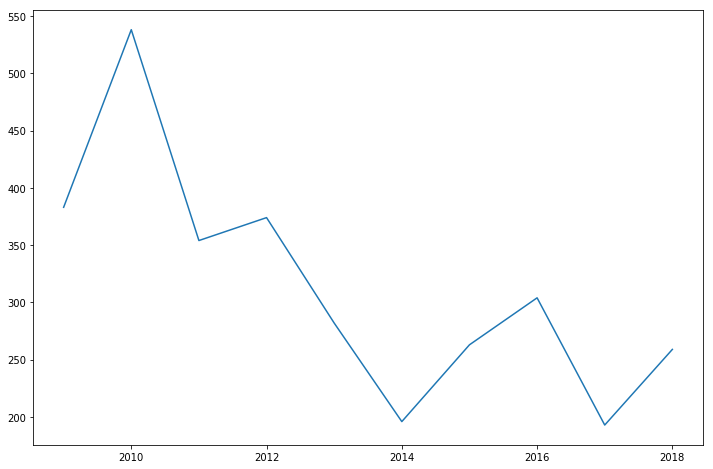

In [55]:
plt.figure(figsize=(12,8))
plt.plot(df1[df1.year < 2019].groupby('year')['spill_street_address'].count())

#### _All observations grouped by month of the year._

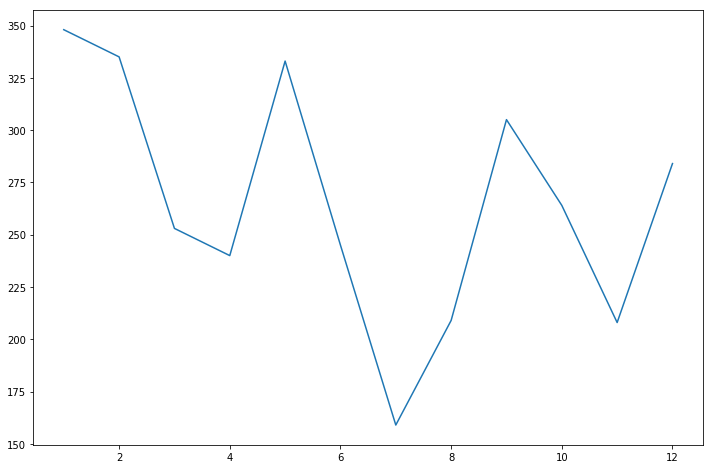

In [56]:
plt.figure(figsize=(12,8))
plt.plot(df1.groupby('month')['spill_street_address'].count())

#### _Colder months mean more grease clogs. Grease solidifies in colder temperatures._

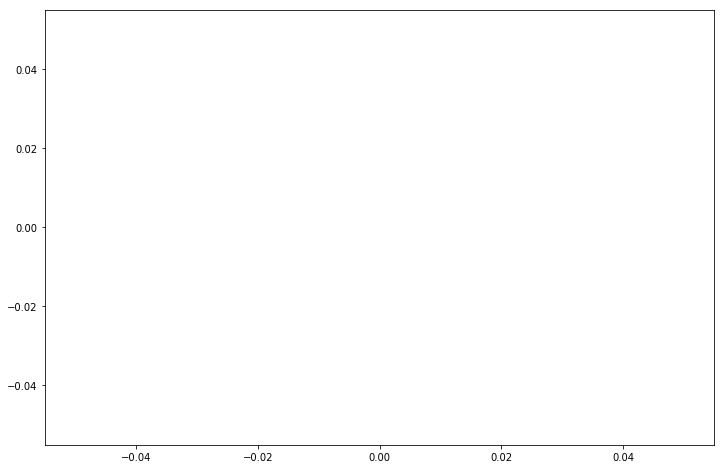

In [57]:
plt.figure(figsize=(12,8))
plt.plot(df1[(df1.root_cause == 'grease') & (df1.year < 2019)].groupby('month')['spill_street_address'].count())